# Results

In this notebook we compare the results from the different classifiers, and generate some plots to use in the final report.

In [51]:
%reload_ext autoreload
%autoreload 2

In [63]:
import bz2
import os
import pickle
import sys 
import pandas as pd

sys.path.append(os.path.abspath('../src'))
from fact_classification import *


Define the list of models to compare:

In [75]:
model_list = ['AdaBoost', 'GradientBoosting', 'NaiveBayes', 'RandomForest', 'SVM'] #'LogisticRegression'

### Load and merge results table

In [76]:
df_score_train = pd.DataFrame()
df_score_test = pd.DataFrame()

for model in model_list:
    df_train, df_test = score_loading(f'{model}_score')
    df_score_train = pd.concat([df_score_train, df_train])
    df_score_test = pd.concat([df_score_test, df_test])    

### Load trained models

In [77]:
models = {}

for model in model_list:
  with bz2.open(f'../models/{model}.bz2') as f:
    models[model] = pickle.load(f)


Extract data for plotting.

In [79]:
def to_long(models):
    features_list = []
    models_list = []
    mean_fit_time_list = []
    mean_score_time_list = []
    for model, gscv in models.items():
        for feature, clf in gscv.items():
            mean_fit_times = clf.cv_results_['mean_fit_time']
            mean_score_times = clf.cv_results_['mean_score_time']
            for i in range(len(mean_fit_times)):
                models_list.append(model)
                features_list.append(feature)
                mean_fit_time_list.append(mean_fit_times[i])
                mean_score_time_list.append(mean_score_times[i])
    data = pd.DataFrame({
        'Model': models_list,
        'Feature': features_list,
        'Mean_fit_time': mean_fit_time_list,
        'Mean_score_time': mean_score_time_list
    })
    return data

data = to_long(models)

In [80]:
sort_order = data.groupby(by='Feature')['Mean_fit_time'].mean().sort_values()

['E', 'N', 'N_E', 'P', 'N_P', 'N_W', 'N_W_E', 'N_W_P', 'N_W_P_E', 'W']

### Plot training times

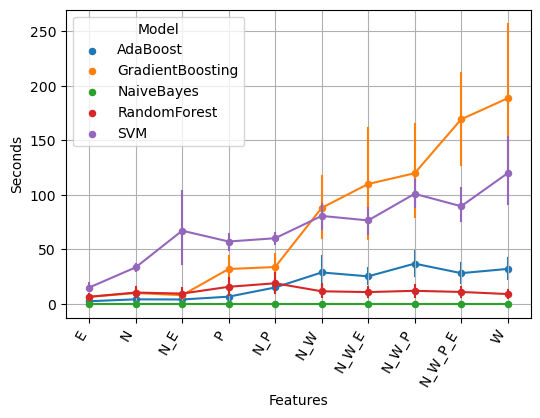

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data, x='Feature', y='Mean_fit_time', hue='Model', order=sort_order.index, markers='.', ax=ax, errwidth=0.5)
plt.setp(ax.lines, linewidth=1.5)
ax.set_xticklabels(sort_order.index, rotation=60, ha='right')
ax.grid()
ax.set_xlabel('Features')
ax.set_ylabel('Seconds')
plt.show()

### Plot scoring times

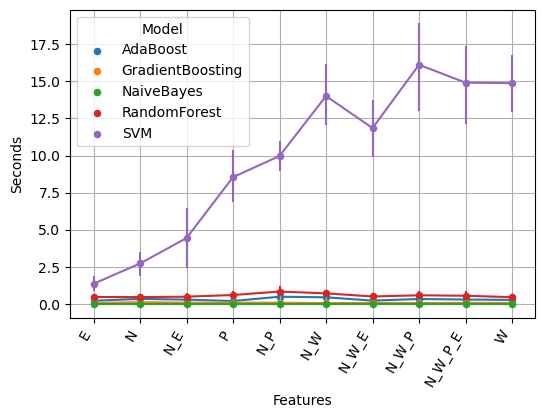

In [82]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data, x='Feature', y='Mean_score_time', hue='Model', order=sort_order.index, markers='.', ax=ax, errwidth=0.5)
plt.setp(ax.lines, linewidth=1.5)
ax.set_xticklabels(sort_order.index, rotation=60, ha='right')
ax.grid()
ax.set_xlabel('Features')
ax.set_ylabel('Seconds')
plt.show()

### Plot test scores
Show training and testing weighted f1-scores as function of features. Sort according to ascending SVM weighted f1-score.

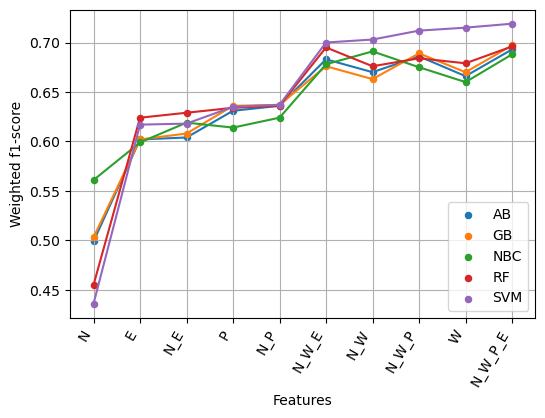

In [83]:
plot_train_test_score(df_score_train, df_score_test, method='compare', order_by='f_wavg')

### Top 10 combinations of classifiers and features

In [84]:
df_score_test.drop_duplicates().sort_values(by=['f_wavg'], ascending=False).head(10)

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
9,SVM,N_W_P_E,0.796,0.408,0.669,0.717,0.880,0.382,0.524,0.727,0.836,0.394,0.587,0.719
1,SVM,W,0.798,0.424,0.634,0.711,0.858,0.371,0.558,0.722,0.827,0.396,0.594,0.715
7,SVM,N_W_P,0.803,0.389,0.638,0.711,0.852,0.413,0.530,0.716,0.827,0.400,0.579,0.712
4,SVM,N_W,0.809,0.351,0.633,0.709,0.822,0.457,0.525,0.701,0.816,0.397,0.574,0.703
8,SVM,N_W_E,0.803,0.359,0.621,0.703,0.821,0.430,0.535,0.699,0.812,0.391,0.575,0.700
9,GB,N_W_P_E,0.744,0.504,0.728,0.712,0.951,0.222,0.436,0.729,0.835,0.308,0.546,0.697
9,RF,N_W_P_E,0.793,0.322,0.664,0.704,0.844,0.419,0.479,0.697,0.818,0.364,0.557,0.696
8,RF,N_W_E,0.788,0.329,0.676,0.705,0.853,0.421,0.464,0.699,0.819,0.369,0.550,0.695
9,AB,N_W_P_E,0.746,0.441,0.717,0.703,0.933,0.262,0.426,0.720,0.829,0.328,0.534,0.693
4,NBC,N_W,0.763,0.448,0.614,0.687,0.878,0.238,0.525,0.710,0.816,0.311,0.566,0.691


### Best results per model

In [85]:
df_best_per_algorithm = df_score_test.sort_values(by='f_wavg', ascending=False).groupby('algorithm').head(1)
display(df_best_per_algorithm)
to_latex(df_best_per_algorithm)

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
9,SVM,N_W_P_E,0.796,0.408,0.669,0.717,0.880,0.382,0.524,0.727,0.836,0.394,0.587,0.719
9,GB,N_W_P_E,0.744,0.504,0.728,0.712,0.951,0.222,0.436,0.729,0.835,0.308,0.546,0.697
9,RF,N_W_P_E,0.793,0.322,0.664,0.704,0.844,0.419,0.479,0.697,0.818,0.364,0.557,0.696
9,AB,N_W_P_E,0.746,0.441,0.717,0.703,0.933,0.262,0.426,0.720,0.829,0.328,0.534,0.693
4,NBC,N_W,0.763,0.448,0.614,0.687,0.878,0.238,0.525,0.710,0.816,0.311,0.566,0.691


\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
SVM & N\_W\_P\_E & 0.796 & 0.408 & 0.669 & 0.717 & 0.880 & 0.382 & 0.524 & 0.727 & 0.836 & 0.394 & 0.587 & 0.719 \\
GB & N\_W\_P\_E & 0.744 & 0.504 & 0.728 & 0.712 & 0.951 & 0.222 & 0.436 & 0.729 & 0.835 & 0.308 & 0.546 & 0.697 \\
RF & N\_W\_P\_E & 0.793 & 0.322 & 0.664 & 0.704 & 0.844 & 0.419 & 0.479 & 0.697 & 0.818 & 0.364 & 0.557 & 0.696 \\
AB & N\_W\_P\_E & 0.746 & 0.441 & 0.717 & 0.703 & 0.933 & 0.262 & 0.426 & 0.720 & 0.829 & 0.328 & 0.534 & 0.693 \\
NBC & N\_W & 0.763 & 0.448 & 0.614 & 0.687 & 0.878 & 0.238 & 0.525 & 0.710 & 0.816 & 0.311 & 0.566 & 0.691 \\
\bottomrule
\end{tabular}



## All training scores

In [86]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,AB,N,0.682,1.000,0.451,0.661,0.952,0.001,0.136,0.666,0.795,0.002,0.209,0.578
1,AB,W,0.795,0.655,0.777,0.776,0.953,0.244,0.546,0.786,0.867,0.355,0.641,0.762
2,AB,P,0.781,0.405,0.577,0.695,0.912,0.112,0.481,0.731,0.841,0.176,0.525,0.700
3,AB,E,0.736,0.538,0.661,0.699,0.950,0.004,0.397,0.726,0.830,0.008,0.496,0.669
4,AB,N_W,0.811,0.524,0.702,0.757,0.915,0.288,0.584,0.774,0.860,0.371,0.638,0.759
5,AB,N_P,0.791,0.434,0.588,0.708,0.910,0.119,0.520,0.739,0.846,0.187,0.552,0.711
6,AB,N_E,0.741,0.370,0.651,0.683,0.944,0.009,0.418,0.727,0.831,0.018,0.509,0.673
7,AB,N_W_P,0.822,0.619,0.745,0.784,0.937,0.303,0.612,0.797,0.876,0.407,0.672,0.781
8,AB,N_W_E,0.822,0.538,0.706,0.766,0.918,0.304,0.605,0.783,0.867,0.388,0.652,0.769
9,AB,N_W_P_E,0.830,0.616,0.744,0.788,0.935,0.307,0.636,0.802,0.879,0.410,0.685,0.786


## All testing scores

In [87]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,AB,N,0.626,0.000,0.452,0.507,0.977,0.000,0.060,0.620,0.763,0.000,0.105,0.499
1,AB,W,0.716,0.493,0.754,0.700,0.960,0.215,0.340,0.709,0.820,0.299,0.469,0.666
2,AB,P,0.713,0.359,0.557,0.631,0.917,0.104,0.360,0.674,0.802,0.162,0.437,0.631
3,AB,E,0.674,0.000,0.698,0.602,0.967,0.000,0.298,0.677,0.794,0.000,0.418,0.602
4,AB,N_W,0.729,0.456,0.664,0.680,0.922,0.247,0.387,0.701,0.814,0.320,0.489,0.670
5,AB,N_P,0.714,0.373,0.576,0.638,0.924,0.116,0.357,0.679,0.806,0.176,0.441,0.636
6,AB,N_E,0.675,0.273,0.690,0.632,0.959,0.005,0.310,0.676,0.792,0.009,0.428,0.604
7,AB,N_W_P,0.739,0.451,0.712,0.698,0.937,0.252,0.407,0.716,0.826,0.323,0.518,0.686
8,AB,N_W_E,0.741,0.421,0.683,0.688,0.916,0.249,0.430,0.709,0.819,0.313,0.528,0.683
9,AB,N_W_P_E,0.746,0.441,0.717,0.703,0.933,0.262,0.426,0.720,0.829,0.328,0.534,0.693


## Export to LaTeX

In [88]:
to_latex(df_score_train)


\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
AB & N & 0.682 & 1.000 & 0.451 & 0.661 & 0.952 & 0.001 & 0.136 & 0.666 & 0.795 & 0.002 & 0.209 & 0.578 \\
AB & W & 0.795 & 0.655 & 0.777 & 0.776 & 0.953 & 0.244 & 0.546 & 0.786 & 0.867 & 0.355 & 0.641 & 0.762 \\
AB & P & 0.781 & 0.405 & 0.577 & 0.695 & 0.912 & 0.112 & 0.481 & 0.731 & 0.841 & 0.176 & 0.525 & 0.700 \\
AB & E & 0.736 & 0.538 & 0.661 & 0.699 & 0.950 & 0.004 & 0.397 & 0.726 & 0.830 & 0.008 & 0.496 & 0.669 \\
AB & N\_W & 0.811 & 0.524 & 0.702 & 0.757 & 0.915 & 0.288 & 0.584 & 0.774 & 0.860 & 0.371 & 0.638 & 0.759 \\
AB & N\_P & 0.791 & 0.434 & 0.588 & 0.708 & 0.910 & 0.119 & 0.520 & 0.739 & 0.846 & 0.187 & 0.552 & 0.711 \\
AB & N\_E & 0.741 & 0.370 & 0.651 & 0.683 & 0.944 & 0.009 & 0.418 & 0.727 & 0.831 & 0.018 & 0.509 & 0.673 \\
AB & N\_W\_P & 0.822 & 0.619 & 0.745 & 0.784 & 0.937 & 0.303 & 0

In [89]:
to_latex(df_score_test)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
AB & N & 0.626 & 0.000 & 0.452 & 0.507 & 0.977 & 0.000 & 0.060 & 0.620 & 0.763 & 0.000 & 0.105 & 0.499 \\
AB & W & 0.716 & 0.493 & 0.754 & 0.700 & 0.960 & 0.215 & 0.340 & 0.709 & 0.820 & 0.299 & 0.469 & 0.666 \\
AB & P & 0.713 & 0.359 & 0.557 & 0.631 & 0.917 & 0.104 & 0.360 & 0.674 & 0.802 & 0.162 & 0.437 & 0.631 \\
AB & E & 0.674 & 0.000 & 0.698 & 0.602 & 0.967 & 0.000 & 0.298 & 0.677 & 0.794 & 0.000 & 0.418 & 0.602 \\
AB & N\_W & 0.729 & 0.456 & 0.664 & 0.680 & 0.922 & 0.247 & 0.387 & 0.701 & 0.814 & 0.320 & 0.489 & 0.670 \\
AB & N\_P & 0.714 & 0.373 & 0.576 & 0.638 & 0.924 & 0.116 & 0.357 & 0.679 & 0.806 & 0.176 & 0.441 & 0.636 \\
AB & N\_E & 0.675 & 0.273 & 0.690 & 0.632 & 0.959 & 0.005 & 0.310 & 0.676 & 0.792 & 0.009 & 0.428 & 0.604 \\
AB & N\_W\_P & 0.739 & 0.451 & 0.712 & 0.698 & 0.937 & 0.252 & 0